In [1]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance
import scipy.ndimage.filters
import copy
import glob
from matplotlib import animation
import matplotlib as mpl
import scipy as sci
import matplotlib.ticker as ticker
from pylab import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as fm
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator


# Edit the font, font size, and axes width
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['font.family'] = 'Sans'
#mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

%matplotlib inline

# Read in data for RMSD of H2-H5 to bound crystal structure 1QKR

In [2]:
# Define list of data directories
data_dirs = [
    "../outputs/",
    # Add more directories as needed
]

outprefix = "Nterm_holoh1"
dir_prefix = "pull_"
force_replicas = pd.DataFrame()

# Define column names
column_names = ["time", "pp.proj","pp2.proj", "pp.ext","pp2.ext","real","d1.x","d1.y", "d1.z",
                "cmap","H1_rmsd","apo_rmsd","holo_rmsd","apo_eq_rmsd", "cnumber_bundle","cnumber_bundle_heavy",
                "h1_bundle"]

# Iterate over data directories
for data_dir in data_dirs:
    # List all subdirectories in data_dir
    subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for subdir in subdirs:
        try:
            force_value = int(subdir.split('_')[1].split('pN')[0])
        except ValueError as e:
            print(e)
            continue
        force_dir = os.path.join(data_dir, subdir)
        y_dirs = [d for d in os.listdir(force_dir) if os.path.isdir(os.path.join(force_dir, d))]
        for y in y_dirs:
            colvar_files = glob.glob(os.path.join(force_dir, y, f"{y}*.COLVAR_b"))
            if colvar_files:
                try:
                    temp_df = pd.read_csv(colvar_files[0], delim_whitespace=True, skiprows=1, names=column_names)
                    temp_df['force'] = force_value
                    temp_df['replica'] = int(y)
                    temp_df['path'] = colvar_files[0]
                    force_replicas = pd.concat([force_replicas, temp_df], ignore_index=True)
                except Exception as e:
                    print(f"Error reading {colvar_files[0]}: {e}")

# Reset index
force_replicas.reset_index(drop=True, inplace=True)

# Define color map
color_map = {26: '#1f77b4', 27: '#2ca02c', 28: '#8c564b', 29:'#e377c2', 30:'#7f7f7f'}
force_replicas['color'] = force_replicas['replica'].map(color_map)

# Print DataFrame info
print(force_replicas.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  1363 non-null   float64
 1   pp.proj               1363 non-null   float64
 2   pp2.proj              1363 non-null   float64
 3   pp.ext                1363 non-null   float64
 4   pp2.ext               1363 non-null   float64
 5   real                  1363 non-null   float64
 6   d1.x                  1363 non-null   float64
 7   d1.y                  1363 non-null   float64
 8   d1.z                  1363 non-null   float64
 9   cmap                  1363 non-null   float64
 10  H1_rmsd               1363 non-null   float64
 11  apo_rmsd              1363 non-null   float64
 12  holo_rmsd             1363 non-null   float64
 13  apo_eq_rmsd           1363 non-null   float64
 14  cnumber_bundle        1363 non-null   float64
 15  cnumber_bundle_heavy 

## Plot data as probability density

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


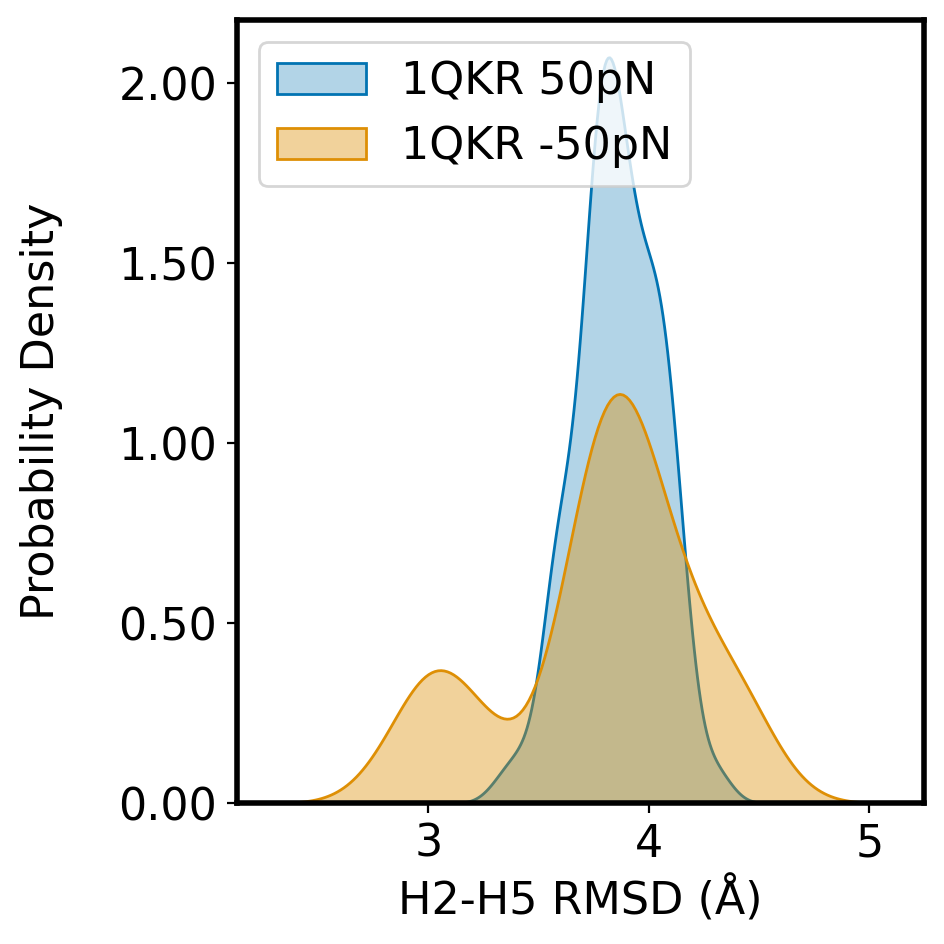

In [3]:
# Plotting
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")

force_values = [-50,50]
adj= ["1QKR 50pN","1QKR -50pN"]
fig, axes = plt.subplots(figsize=(5,5), dpi=200)
var="apo_rmsd"

# ns to xtc output 
start_ns = 120
end_ns = 170

start_ps = start_ns*1000000/1500
end_ps = end_ns*1000000/1500

for i, force_value in enumerate(force_values):
    subset_df = force_replicas[(force_replicas['force'] == force_value) & (force_replicas['time'] >= start_ps) & 
        (force_replicas['time'] <= end_ps)]
    sns.kdeplot(x=subset_df[var], ax=axes, fill=True, label=adj[i], log_scale=(False,False),color=palette[i],alpha=0.3 + 0.1 * i)

# Format y-axis tick marks to two significant figures
formatter = ticker.FuncFormatter(lambda x, _: f'{x:0.2f}')
axes.yaxis.set_major_formatter(formatter)

axes.set_xlabel(r"H2-H5 RMSD (Å)")
axes.set_ylabel(r"Probability Density", rotation=90, labelpad=20)

# Add the legend outside the plots
fig.tight_layout()
plt.legend(loc='upper left', ncols=1)
#fig.savefig("Fig5-RMSD.pdf", dpi=300)

# Read in Aligned data

In [6]:
# Define list of data directories
data_dirs = [
    "../outputs/",
]

outprefix="Nterm_apo"
dir_prefix="apo_"
force_replicas_apo = pd.DataFrame()

# Define column names
column_names = ["time", "pp.proj", "pp2.proj", "pp.ext", "pp2.ext", "real",
                "d1.x", "d1.y", "d1.z", "cmap", "cnumber_bundle","cnumber_bundle_heavy","h1_bundle"]

# Iterate over data directories
for data_dir in data_dirs:
    # List all subdirectories in data_dir
    subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    print(subdirs)
    for subdir in subdirs:
        try:
            force_value = int(subdir.split('_')[1].split('pN')[0])
        except ValueError as e:
            print(e)
            continue
        
        force_dir = os.path.join(data_dir, subdir)
        y_dirs = [d for d in os.listdir(force_dir) if os.path.isdir(os.path.join(force_dir, d))]
        
        for y in y_dirs:
            colvar_files = glob.glob(os.path.join(force_dir, y, f"{y}*COLVAR_b"))
            if colvar_files:
                try:
                    temp_df = pd.read_csv(colvar_files[0], delim_whitespace=True, skiprows=1, names=column_names)
                    temp_df['force'] = force_value
                    temp_df['replica'] = int(y)
                    temp_df['path'] = colvar_files[0]
                    force_replicas_apo = pd.concat([force_replicas_apo, temp_df], ignore_index=True)
                except Exception as e:
                    print(f"Error reading {colvar_files[0]}: {e}")

# Reset index
force_replicas_apo.reset_index(drop=True, inplace=True)

# Define color map
color_map = {26: '#1f77b4', 27: '#2ca02c', 28: '#8c564b', 29:'#e377c2', 30:'#7f7f7f'}
force_replicas_apo['color'] = force_replicas_apo['replica'].map(color_map)

# Print DataFrame info
print(force_replicas.info())

['apo_0pN', 'pull_-50pN', 'pull_50pN']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  1363 non-null   float64
 1   pp.proj               1363 non-null   float64
 2   pp2.proj              1363 non-null   float64
 3   pp.ext                1363 non-null   float64
 4   pp2.ext               1363 non-null   float64
 5   real                  1363 non-null   float64
 6   d1.x                  1363 non-null   float64
 7   d1.y                  1363 non-null   float64
 8   d1.z                  1363 non-null   float64
 9   cmap                  1363 non-null   float64
 10  H1_rmsd               1363 non-null   float64
 11  apo_rmsd              1363 non-null   float64
 12  holo_rmsd             1363 non-null   float64
 13  apo_eq_rmsd           1363 non-null   float64
 14  cnumber_bundle        1363 non-nu

## Plot H1 Distance to Bundle

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


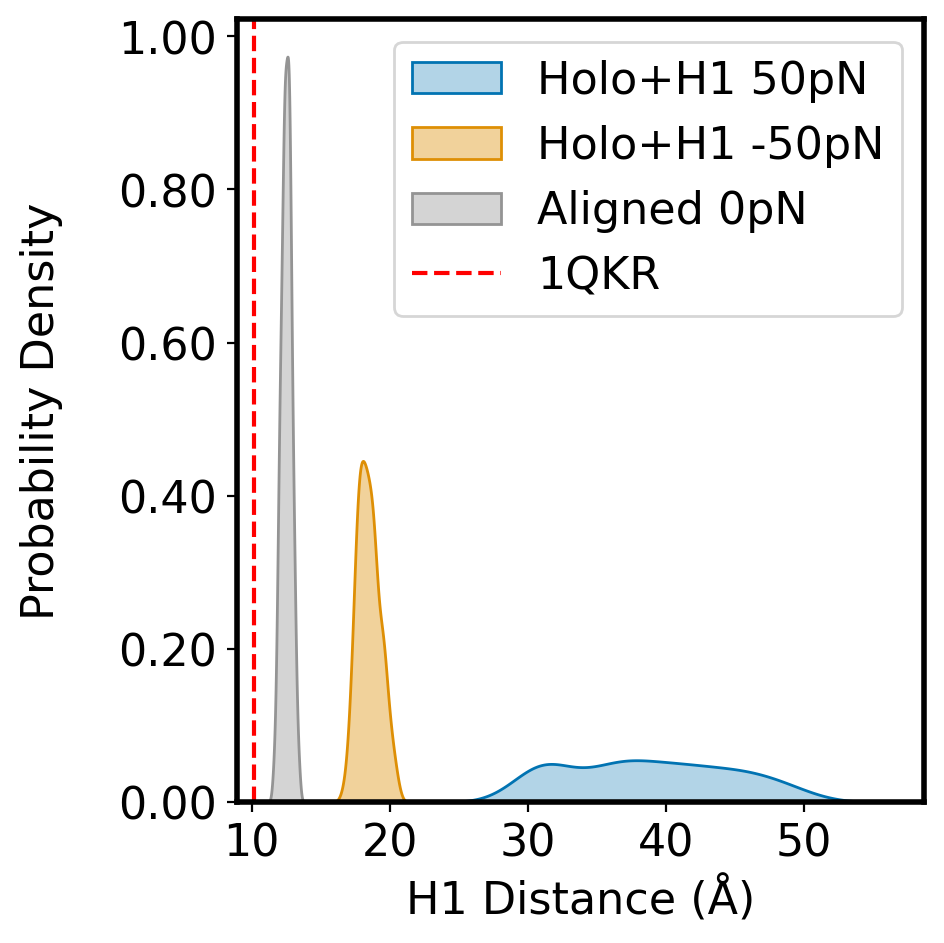

In [7]:
# Plotting
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")

force_values = [-50, 50]
adj= ["Holo+H1 50pN","Holo+H1 -50pN"]
fig, axes = plt.subplots(figsize=(5,5), dpi=200)
var="h1_bundle"

# ns to xtc output 
start_ns = 120
end_ns = 170

start_ps = start_ns*1000000/1500
end_ps = end_ns*1000000/1500

for i, force_value in enumerate(force_values):
    subset_df = force_replicas[(force_replicas['force'] == force_value) & (force_replicas['time'] >= start_ps) & 
        (force_replicas['time'] <= end_ps)]
    sns.kdeplot(x=subset_df[var], ax=axes, fill=True, label=adj[i], log_scale=(False,False),color=palette[i],alpha=0.3 + 0.1 * i )

# plot APO data 
subset_df_apo = force_replicas_apo[(force_replicas_apo['force'] == 0) &
    (force_replicas_apo['time'] >= start_ps) & (force_replicas_apo['time'] <= end_ps)]
sns.kdeplot(x=subset_df_apo[var], ax=axes, fill=True, label='Aligned 0pN', log_scale=(False,False),color=palette[i+6],alpha=0.3 + 0.1 * i )

# plot crystal structure data 
plt.axvline(x=10.162, color='red', linestyle='--', label='1QKR')

plt.legend(loc='upper right', ncols=1)


formatter = ticker.FuncFormatter(lambda x, _: f'{x:0.2f}')
axes.yaxis.set_major_formatter(formatter)

axes.set_xlabel(r"H1 Distance (Å)")
axes.set_ylabel(r"Probability Density", rotation=90, labelpad=20)
# Add the legend outside the plots

fig.tight_layout()

#plt.show()
fig.savefig("legend.pdf", dpi=300)

## Plot coordination of heavy atoms between H1 and H2-H5

/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


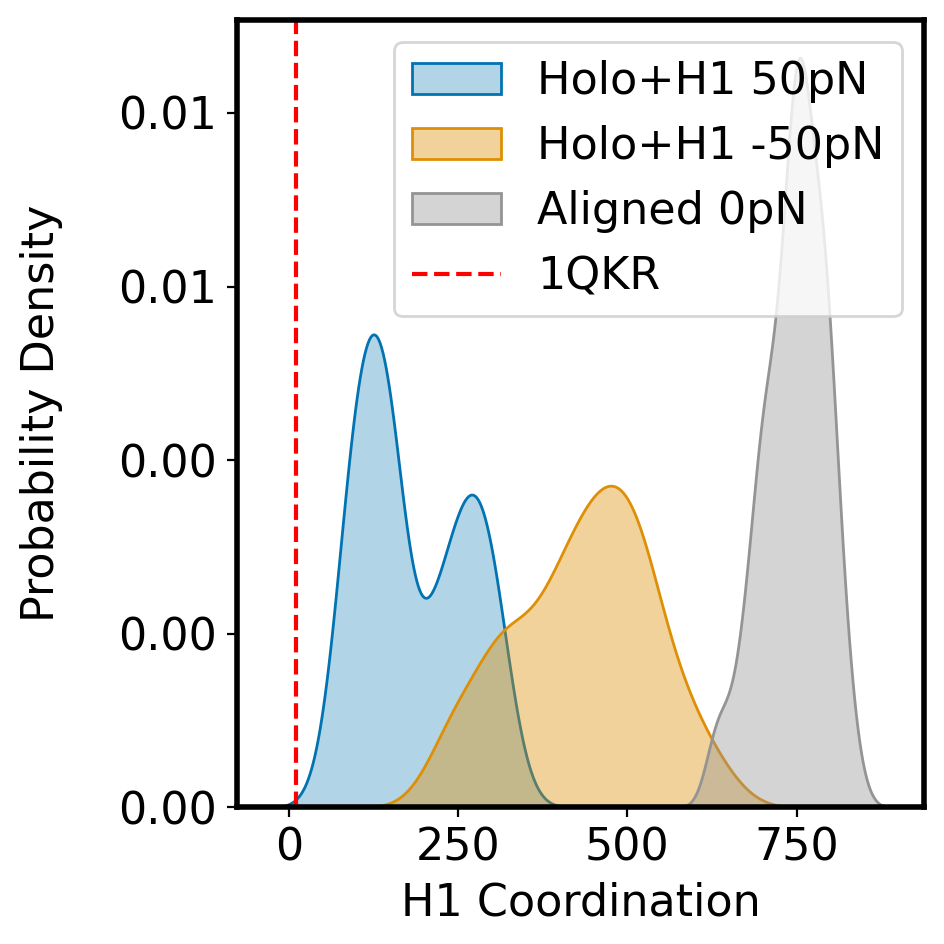

In [8]:
# Plotting
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")

force_values = [-50, 50]
adj= ["Holo+H1 50pN","Holo+H1 -50pN"]
fig, axes = plt.subplots(figsize=(5,5), dpi=200)
var="cnumber_bundle_heavy"

# ns to xtc output 
start_ns = 120
end_ns = 170

start_ps = start_ns*1000000/1500
end_ps = end_ns*1000000/1500

for i, force_value in enumerate(force_values):
    subset_df = force_replicas[(force_replicas['force'] == force_value) & (force_replicas['time'] >= start_ps) & 
        (force_replicas['time'] <= end_ps)]
    sns.kdeplot(x=subset_df[var], ax=axes, fill=True, label=adj[i], log_scale=(False,False),color=palette[i],alpha=0.3 + 0.1 * i )

# plot APO data 
subset_df_apo = force_replicas_apo[(force_replicas_apo['force'] == 0) &
    (force_replicas_apo['time'] >= start_ps) & (force_replicas_apo['time'] <= end_ps)]
sns.kdeplot(x=subset_df_apo[var], ax=axes, fill=True, label='Aligned 0pN', log_scale=(False,False),color=palette[i+6],alpha=0.3 + 0.1 * i )

# plot crystal structure data 
plt.axvline(x=10.162, color='red', linestyle='--', label='1QKR')

plt.legend(loc='upper right', ncols=1)


formatter = ticker.FuncFormatter(lambda x, _: f'{x:0.2f}')
axes.yaxis.set_major_formatter(formatter)

axes.set_xlabel(r"H1 Coordination")
axes.set_ylabel(r"Probability Density", rotation=90, labelpad=20)
# Add the legend outside the plots

fig.tight_layout()

#plt.show()
fig.savefig("legend.pdf", dpi=300)